In [128]:
import pandas as pd
import locale
import glob
import chardet
import numpy as np
import awswrangler as wr
import boto3

# AWS setup

In [129]:
boto3.setup_default_session(profile_name='patricio_ferreira_fellow_dssgx_24')

In [130]:
bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

# Load data

In [131]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.

    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """

    df = wr.s3.read_csv(path=path, **kwargs)
    return df


In [132]:
#2016 data had a higher number of columns, but we want to keep common columns for all visitor count data

def get_common_columns_across_historic_visitor_counts():
    df_2016 = load_csv_files_from_aws_s3("s3://dssgx-munich-2024-bavarian-forest/raw-data/hourly-historic-visitor-counts-all-sensors/visitor_counts_2016.csv", skiprows=2)



    historic_visitor_counts = load_csv_files_from_aws_s3(
    path=f"s3://{bucket}/{raw_data_folder}/hourly-historic-visitor-counts-all-sensors/export*.csv", skiprows=2)

    col_2016 = df_2016.columns
    col_export = historic_visitor_counts.columns

    common_cols = [col for col in col_2016 if col in col_export]
    
    return common_cols





In [133]:
historic_visitor_counts = load_csv_files_from_aws_s3(
    path=f"s3://{bucket}/{raw_data_folder}/hourly-historic-visitor-counts-all-sensors/*.csv",
    skiprows=2,
    usecols = get_common_columns_across_historic_visitor_counts()

)

historic_visitor_counts.shape

(75696, 96)

# Cleaning

### Format date

In [134]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

    return df

visitor_counts_parsed_dates = parse_german_dates(df=historic_visitor_counts, date_column_name="Time")

### Duplicated Indexes

In [135]:
#for some reason there are duplicated index

visitor_counts_parsed_dates.index.duplicated()

array([False, False, False, ..., False, False, False])

In [136]:
# reset the index to avoid future problems
visitor_counts_parsed_dates.sort_values("Time", ascending=True, inplace=True)
visitor_counts_parsed_dates = visitor_counts_parsed_dates.reset_index(drop=True)


### Mapping

After reviewing all the columns to check for inconsistencies I arrived to a list of tasks that should be done to clean de dataset:

- Drop repeated columns listed in "to_drop". Waldhausreibe Channel 1 (IN and OUT) had a total sum of values of 10 and 13. Brechhäuslau columns were duplicated.
- Create "Bucina_Multi IN" as the sum of cyclist and pedestrians it's not there
- Rename columns that had wrong names


In [137]:
#lists an dictionaries to drop and rename

to_drop = ['Brechhäuslau Fußgänger IN', 'Brechhäuslau Fußgänger OUT', 'Waldhausreibe Channel 1 IN', 'Waldhausreibe Channel 2 OUT']

to_create = 'Bucina_Multi IN' #did not exist sum of pedestrian and cyclists for the MULTI sensor 


to_rename = {'Bucina IN': 'Bucina PYRO IN',
          'Bucina OUT': 'Bucina PYRO OUT',
          'Gsenget IN.1': 'Gsenget Fußgänger IN',
          'Gsenget OUT.1': 'Gsenget Fußgänger OUT',
          'Gfäll Fußgänger IN' : 'Gfäll IN',
          'Gfäll Fußgänger OUT': 'Gfäll OUT',
          'Fredenbrücke Fußgänger IN' : 'Fredenbrücke IN',
          'Fredenbrücke Fußgänger OUT': 'Fredenbrücke OUT',
          'Diensthüttenstraße Fußgänger IN': 'Diensthüttenstraße IN' ,
          'Diensthüttenstraße Fußgänger OUT': 'Diensthüttenstraße OUT',
          'Racheldiensthütte Cyclist OUT' : 'Racheldiensthütte Fahrräder OUT',
          'Racheldiensthütte Pedestrian IN' : 'Racheldiensthütte Fußgänger IN',
          'Racheldiensthütte Pedestrian OUT' : 'Racheldiensthütte Fußgänger OUT',
          'Sagwassersäge Fußgänger IN' : 'Sagwassersäge IN',
          'Sagwassersäge Fußgänger OUT': 'Sagwassersäge OUT',
          'Schwarzbachbrücke Fußgänger IN' : 'Schwarzbachbrücke IN',
          'Schwarzbachbrücke Fußgänger OUT' : 'Schwarzbachbrücke OUT',
          'NPZ_Falkenstein IN' : 'Falkenstein 1 PYRO IN',
          'NPZ_Falkenstein OUT' : 'Falkenstein 1 PYRO OUT',
          'TFG_Falkenstein_1 Fußgänger zum Parkplatz' : 'Falkenstein 1 OUT',
          'TFG_Falkenstein_1 Fußgänger zum HZW' : 'Falkenstein 1 IN',
          'TFG_Falkenstein_2 Fußgänger In Richtung Parkplatz' : 'Falkenstein 2 OUT',
          'TFG_Falkenstein_2 Fußgänger In Richtung TFG' : 'Falkenstein 2 IN',
          'TFG_Lusen IN' : 'Lusen 1 PYRO IN',
          'TFG_Lusen OUT' : 'Lusen 1 PYRO OUT',
          'TFG_Lusen_1 Fußgänger Richtung TFG': 'Lusen 1 EVO IN',
          'TFG_Lusen_1 Fußgänger Richtung Parkplatz' : 'Lusen 1 EVO OUT',
          'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand': 'Lusen 2 IN',
          'TFG_Lusen_2 Fußgänger Richtung Parkplatz' : 'Lusen 2 OUT',
          'TFG_Lusen_3 TFG Lusen 3 IN': 'Lusen 3 IN',
          'TFG_Lusen_3 TFG Lusen 3 OUT': 'Lusen 3 OUT',
          'Waldspielgelände_1 IN': 'Waldspielgelände IN',
          'Waldspielgelände_1 OUT': 'Waldspielgelände OUT',
          'Wistlberg Fußgänger IN' : 'Wistlberg IN',
          'Wistlberg Fußgänger OUT' : 'Wistlberg OUT',
          'Trinkwassertalsperre IN' : 'Trinkwassertalsperre PYRO IN', 
          'Trinkwassertalsperre OUT' : 'Trinkwassertalsperre PYRO OUT'
          }

In [138]:
#Create copy of visitors_counts_parsed_dates
df = visitor_counts_parsed_dates

# Rename columns
df.rename(columns=to_rename, inplace=True)

# Drop columns
df.drop(columns=to_drop, inplace=True)

# Create Bucina Multi IN
df['Bucina_Multi IN'] = df["Bucina_Multi Fahrräder IN"] + df["Bucina_Multi Fußgänger IN"]

### Explore and analyze daylight saving time effect on data

In [139]:
# Check gap between entries: Every jump should be of one hour, but we can see in the print before that there are 7 gaps of 2hs and 7 of 0hs

df.sort_values("Time", ascending=True, inplace=True)

intervals = df.Time.diff().dropna()

intervals.value_counts()

Time
0 days 01:00:00    75677
0 days 02:00:00        9
0 days 00:00:00        9
Name: count, dtype: int64

In [140]:

# Find the first interval to use as a reference
reference_interval = intervals.iloc[0]

# Check where the intervals differ from the reference interval
different_intervals = intervals[intervals != reference_interval]

print("Intervals that differ from the reference interval:")
different_intervals

Intervals that differ from the reference interval:


2066    0 days 02:00:00
2067    0 days 00:00:00
10802   0 days 02:00:00
10803   0 days 00:00:00
19538   0 days 02:00:00
19539   0 days 00:00:00
28442   0 days 02:00:00
28443   0 days 00:00:00
37178   0 days 02:00:00
37179   0 days 00:00:00
45914   0 days 02:00:00
45915   0 days 00:00:00
54650   0 days 02:00:00
54651   0 days 00:00:00
63387   0 days 02:00:00
63386   0 days 00:00:00
72290   0 days 02:00:00
72291   0 days 00:00:00
Name: Time, dtype: timedelta64[ns]

While checking the rows we discovered that these rows are the only that have NaN values for all columns

In [141]:
pd.set_option('display.max_columns', None)
df[df.loc[:, df.columns != "Time"].isna().all(axis=1)]

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
0     2016-01-01 00:00:00                      NaN                       NaN   
1     2016-01-01 01:00:00                      NaN                       NaN   
2     2016-01-01 02:00:00                      NaN                       NaN   
3     2016-01-01 03:00:00                      NaN                       NaN   
4     2016-01-01 04:00:00                      NaN                       NaN   
...                   ...                      ...                       ...   
37178 2020-03-29 03:00:00                      NaN                       NaN   
45915 2021-03-28 03:00:00                      NaN                       NaN   
54650 2022-03-27 03:00:00                      NaN                       NaN   
63386 2023-03-26 03:00:00                      NaN                       NaN   
72291 2024-03-31 03:00:00                      NaN                       NaN   

       Bayerisch Eisenstein Fußgänger IN  Bayerisch Eisenstein Fußgänger OUT  \
0                                    NaN                                 NaN   
1                                    NaN                                 NaN   
2                                    NaN                                 NaN   
3                                    NaN                                 NaN   
4                                    NaN                                 NaN   
...                                  ...                                 ...   
37178                                NaN                                 NaN   
45915                                NaN                                 NaN   
54650                                NaN                                 NaN   
63386                                NaN                                 NaN   
72291                                NaN                                 NaN   

       Bayerisch Eisenstein Fahrräder IN  Bayerisch Eisenstein Fahrräder OUT  \
0                                    NaN                                 NaN   
1                                    NaN                                 NaN   
2                                    NaN                                 NaN   
3                                    NaN                                 NaN   
4                                    NaN                                 NaN   
...                                  ...                                 ...   
37178                                NaN                                 NaN   
45915                                NaN                                 NaN   
54650                                NaN                                 NaN   
63386                                NaN                                 NaN   
72291                                NaN                                 NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Bucina PYRO IN  Bucina PYRO OUT  \
0                  NaN               NaN             NaN              NaN   
1                  NaN               NaN             NaN              NaN   
2                  NaN               NaN             NaN              NaN   
3                  NaN               NaN             NaN              NaN   
4                  NaN               NaN             NaN              NaN   
...                ...               ...             ...              ...   
37178              NaN               NaN             NaN              NaN   
45915              NaN               NaN             NaN              NaN   
54650              NaN               NaN             NaN              NaN   
63386              NaN               NaN             NaN              NaN   
72291              NaN               NaN             NaN              NaN   

       Bucina_Multi OUT  Bucina_Multi Fußgänger IN  Bucina_Multi Fahrräder IN  \
0                   NaN                        NaN                        NaN   
1                   NaN                        NaN 

In [142]:
print("Example of problem: At the end of march every year skips a line")
print(df[["Time", "Bucina_Multi IN"]][72289: ].head(5))

Example of problem: At the end of march every year skips a line
                     Time  Bucina_Multi IN
72289 2024-03-31 01:00:00              0.0
72290 2024-03-31 03:00:00              0.0
72291 2024-03-31 03:00:00              NaN
72292 2024-03-31 04:00:00              0.0
72293 2024-03-31 05:00:00              1.0


We decided to change every repeated row to fill the "02:00" missing, and imputate that row with the values from the inmediately preceading row

In [143]:
index_wrong_time =different_intervals[different_intervals == "0 days 02:00:00"].index

# impute values from the next row
for idx in index_wrong_time:
    df.loc[idx, 'Time'] = df.loc[idx, 'Time'] - pd.Timedelta(hours=1) # sustract one hour to deal with summer daylight savings
    df.loc[idx, df.columns != 'Time'] = df.loc[idx +1, df.columns != 'Time'] #impute the values from the 03:00 am hourly slot

In [144]:
df.loc[idx, df.columns != 'Time'] = df.loc[idx +1, df.columns != 'Time'] #impute the values from the 03:00 am hourly slot

Now for further work we can set the Time column as index

In [145]:
df = df.set_index('Time').sort_index()

In [146]:
#adhoc solution for 2024
df.loc["2024-03-31 03:00:00", df.columns] = df.loc["2024-03-31 04:00:00", df.columns]

### Problems with overlaping data

Some sensors have data when they should not. For example Bucina_Multi replaced Bucina PYRO, so when the records for Multi starts, PYRO should be all NaN.

In [147]:
# dict of non replaced sensors that have wrong data

dict_non_replaced = {'2020-07-30 00:00:00' : ['Lusen 1 PYRO IN', 'Lusen 1 PYRO OUT'],
                     '2022-12-20 00:00:00' : ['Lusen 3 IN', 'Lusen 3 OUT'],
                     '2022-10-12 00:00:00' : ['Gsenget IN', 'Gsenget OUT']}

for key, columns in dict_non_replaced.items():
    timestamp = pd.to_datetime(key)  # Convert the key to a datetime object
    # Set the values to NaN for the specified columns where the index is earlier than the timestamp
    df.loc[df.index < timestamp, columns] = np.nan

In [148]:
#dict of replaced sensors variables

merge = {'Bucina MERGED IN' : ['Bucina PYRO IN', 'Bucina_Multi IN'],
        'Bucina MERGED OUT' : ['Bucina PYRO OUT', 'Bucina_Multi OUT'],
        'Falkenstein 1 MERGED IN': ['Falkenstein 1 PYRO IN', 'Falkenstein 1 IN'],
        'Falkenstein 1 MERGED OUT':['Falkenstein 1 PYRO OUT', 'Falkenstein 1 OUT'],
        'Lusen 1 MERGED IN':['Lusen 1 PYRO IN', 'Lusen 1 EVO IN'],
        'Lusen 1 MERGED OUT':['Lusen 1 PYRO OUT', 'Lusen 1 EVO OUT'],
        'Trinkwassertalsperre MERGED IN':['Trinkwassertalsperre PYRO IN', 'Trinkwassertalsperre_MULTI IN'],
        'Trinkwassertalsperre MERGED OUT':['Trinkwassertalsperre PYRO OUT', 'Trinkwassertalsperre_MULTI OUT'] 
        }

In [149]:
def check_column_overlap(dataframe, columns_dict):

    """Function to check if some selected columns (the ones that have replaced sensors) have overlapping records"""
    
    for key, columns in columns_dict.items():
        if len(columns) != 2:
            print(f"Error: The value for key '{key}' does not contain exactly two columns.")
            continue
        
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                print(f"Overlap found in columns: {col1} and {col2}")
            else:
                print(f"No overlap in columns: {col1} and {col2}")
        else:
            print(f"Columns {col1} or {col2} not found in the dataframe")

check_column_overlap(df, merge)

Overlap found in columns: Bucina PYRO IN and Bucina_Multi IN
Overlap found in columns: Bucina PYRO OUT and Bucina_Multi OUT
Overlap found in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
Overlap found in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: Lusen 1 PYRO IN and Lusen 1 EVO IN
No overlap in columns: Lusen 1 PYRO OUT and Lusen 1 EVO OUT
Overlap found in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
Overlap found in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


Find the index for when the overlaps start

In [150]:
def find_first_overlap_index(dataframe, columns_dict):
    overlap_indices = {}
    
    for key, columns in columns_dict.items():
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                first_overlap_index = overlap.idxmax()  # idxmax() returns the first index where condition is True
                overlap_indices[key] = first_overlap_index
            else:
                overlap_indices[key] = None  # No overlap found
        else:
            overlap_indices[key] = None  # Columns not found
    
    return overlap_indices

find_first_overlap_index(df, merge)

{'Bucina MERGED IN': Timestamp('2021-05-28 00:00:00'),
 'Bucina MERGED OUT': Timestamp('2021-05-28 00:00:00'),
 'Falkenstein 1 MERGED IN': Timestamp('2022-12-22 12:00:00'),
 'Falkenstein 1 MERGED OUT': Timestamp('2022-12-22 12:00:00'),
 'Lusen 1 MERGED IN': None,
 'Lusen 1 MERGED OUT': None,
 'Trinkwassertalsperre MERGED IN': Timestamp('2016-05-09 00:00:00'),
 'Trinkwassertalsperre MERGED OUT': Timestamp('2016-05-09 00:00:00')}

Fix overlap for **Trinkwassertalsperre**

In [151]:
replacement_date = '2021-06-18 00:00:00'

multi_columns = ['Trinkwassertalsperre_MULTI Fußgänger IN',
                 'Trinkwassertalsperre_MULTI Fußgänger OUT',
                 'Trinkwassertalsperre_MULTI Fahrräder IN',
                 'Trinkwassertalsperre_MULTI Fahrräder OUT',
                 'Trinkwassertalsperre_MULTI IN',
                 'Trinkwassertalsperre_MULTI OUT'
                 ]

pyro_columns = ['Trinkwassertalsperre PYRO IN',
                'Trinkwassertalsperre PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Bucina**

In [152]:
replacement_date = '2021-05-28 00:00:00'

multi_columns = ['Bucina_Multi OUT',
                 'Bucina_Multi Fußgänger IN', 'Bucina_Multi Fahrräder IN',
                 'Bucina_Multi Fahrräder OUT', 'Bucina_Multi Fußgänger OUT',
                 'Bucina_Multi IN'
                 ]

pyro_columns = ['Bucina PYRO IN', 'Bucina PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Falkenstein 1**

In [153]:
replacement_date = '2022-12-22 12:00:00'

multi_columns = ['Falkenstein 1 OUT',
                 'Falkenstein 1 IN']

pyro_columns = ['Falkenstein 1 PYRO IN', 'Falkenstein 1 PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

**Final Check of Overlaps**

In [154]:
check_column_overlap(df, merge)

No overlap in columns: Bucina PYRO IN and Bucina_Multi IN
No overlap in columns: Bucina PYRO OUT and Bucina_Multi OUT
No overlap in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
No overlap in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: Lusen 1 PYRO IN and Lusen 1 EVO IN
No overlap in columns: Lusen 1 PYRO OUT and Lusen 1 EVO OUT
No overlap in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
No overlap in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


### Merge columns for same position

In [155]:
def merge_columns(df):
    """
    Merges columns from replaced sensors in the DataFrame into new combined columns based on a predefined mapping and drops the original columns after merging.

    The function merges multiple related columns into single combined columns using a predefined dictionary (`merge_dict`). 
    For each key-value pair in the dictionary, values from the first column are used, and missing values are filled 
    from the second column. After merging, the original columns used for merging are dropped from the DataFrame.

    Args:
        df (pandas.DataFrame): A DataFrame containing columns to be merged.

    Returns:
        pandas.DataFrame: The modified DataFrame with the new merged columns and original columns removed.
    """
    merge_dict = {
        'Bucina MERGED IN': ['Bucina PYRO IN', 'Bucina_Multi IN'],
        'Bucina MERGED OUT': ['Bucina PYRO OUT', 'Bucina_Multi OUT'],
        'Falkenstein 1 MERGED IN': ['Falkenstein 1 PYRO IN', 'Falkenstein 1 IN'],
        'Falkenstein 1 MERGED OUT': ['Falkenstein 1 PYRO OUT', 'Falkenstein 1 OUT'],
        'Lusen 1 MERGED IN': ['Lusen 1 PYRO IN', 'Lusen 1 EVO IN'],
        'Lusen 1 MERGED OUT': ['Lusen 1 PYRO OUT', 'Lusen 1 EVO OUT'],
        'Trinkwassertalsperre MERGED IN': ['Trinkwassertalsperre PYRO IN', 'Trinkwassertalsperre_MULTI IN'],
        'Trinkwassertalsperre MERGED OUT': ['Trinkwassertalsperre PYRO OUT', 'Trinkwassertalsperre_MULTI OUT']
    }

    # Iterate over each item in the dictionary to merge columns
    for new_col, cols in merge_dict.items():
        # Combine the two columns into one using the first non-null value
        df[new_col] = df[cols[0]].combine_first(df[cols[1]])

    # Drop the original columns used for merging
    cols_to_drop = [col for cols in merge_dict.values() for col in cols]
    df = df.drop(columns=cols_to_drop)

    return df

df = merge_columns(df)


### Check outliers

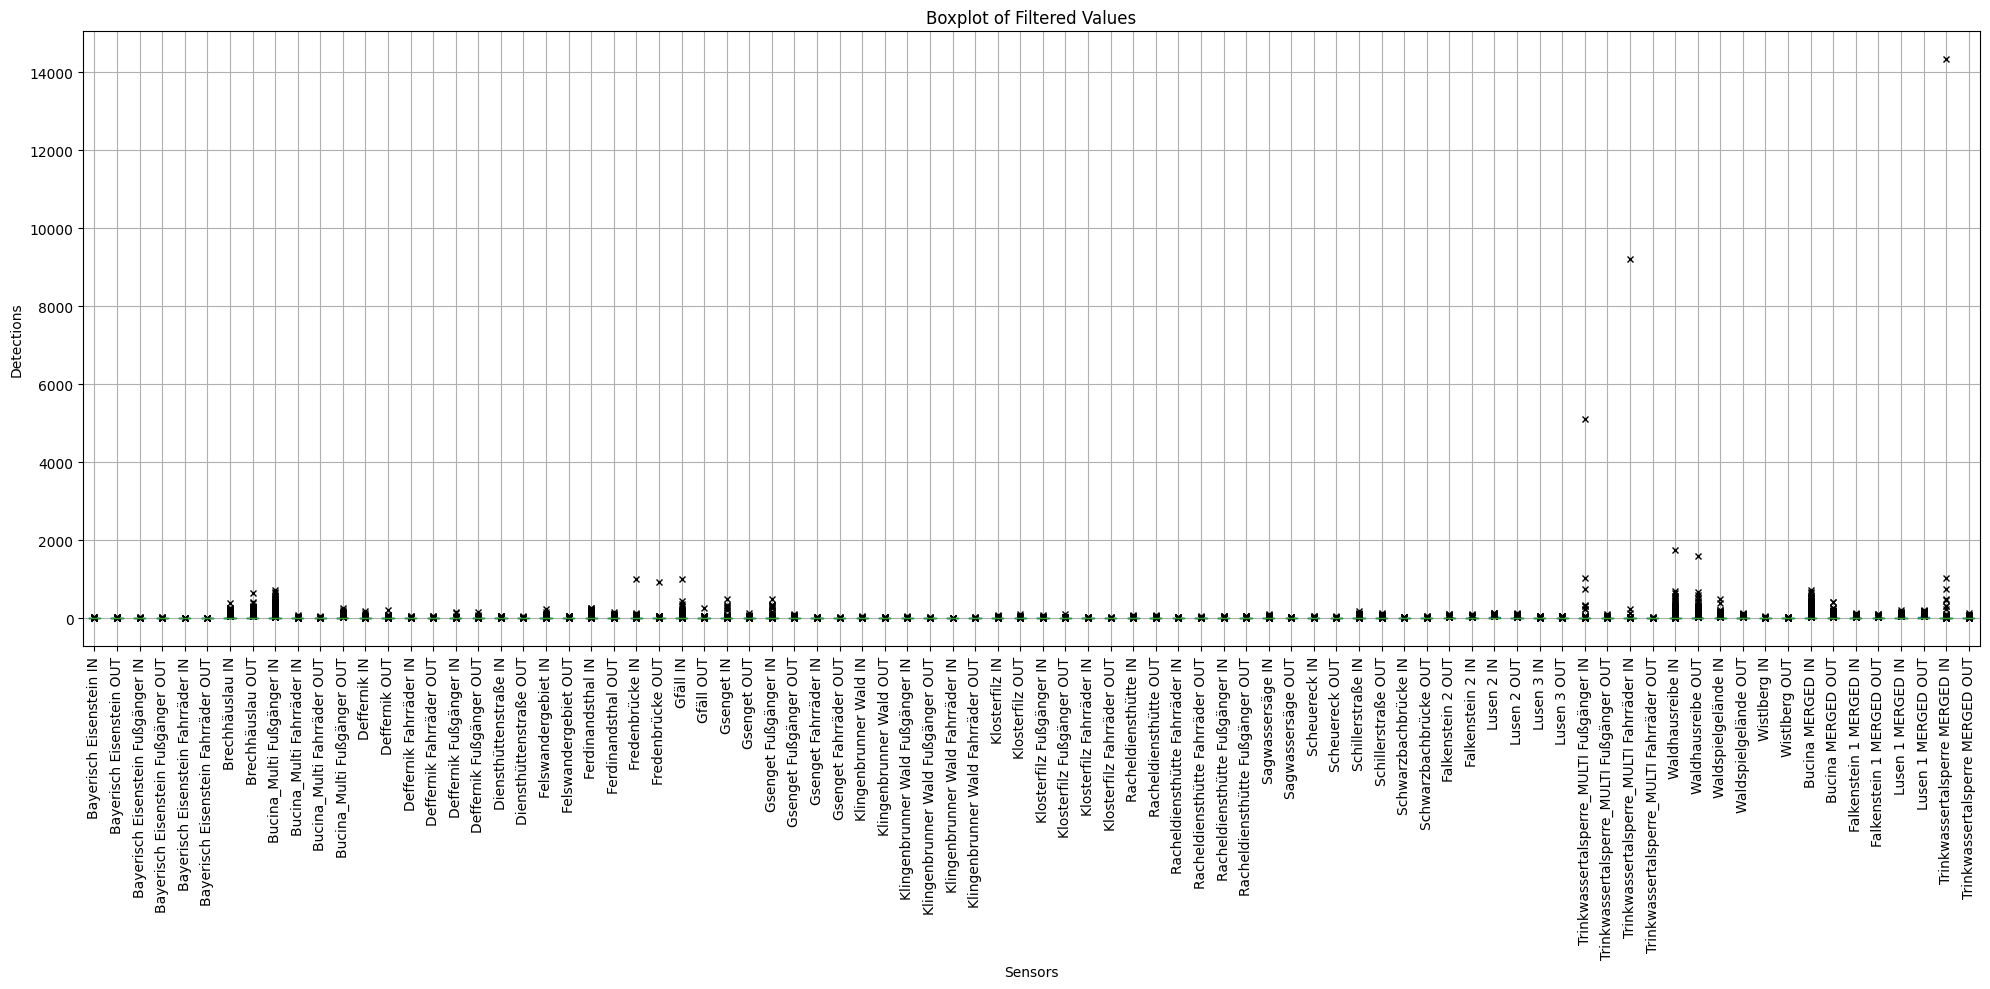

In [156]:
import matplotlib.pyplot as plt

# Replace zero values with NaN
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=1.5,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


Rows with count over 800

In [157]:
# Identify columns where any value exceeds 1000
high_value_columns = df.columns[(df > 800).any()]

df_high_value_columns = df[high_value_columns]
df_high_value_columns[df_high_value_columns > 800].dropna(how='all')


Fredenbrücke IN  Fredenbrücke OUT  Gfäll IN  \
Time                                                               
2017-12-31 00:00:00              NaN               NaN       NaN   
2021-02-04 09:00:00              NaN               NaN    1023.0   
2021-06-04 23:00:00           1011.0               NaN       NaN   
2021-06-06 05:00:00              NaN             944.0       NaN   
2022-05-07 10:00:00              NaN               NaN       NaN   
2022-05-08 11:00:00              NaN               NaN       NaN   

                     Trinkwassertalsperre_MULTI Fußgänger IN  \
Time                                                           
2017-12-31 00:00:00                                      NaN   
2021-02-04 09:00:00                                      NaN   
2021-06-04 23:00:00                                      NaN   
2021-06-06 05:00:00                                      NaN   
2022-05-07 10:00:00                                   5116.0   
2022-05-08 11:00:00                                   1040.0   

                     Trinkwassertalsperre_MULTI Fahrräder IN  \
Time                                                           
2017-12-31 00:00:00                                      NaN   
2021-02-04 09:00:00                                      NaN   
2021-06-04 23:00:00                                      NaN   
2021-06-06 05:00:00                                      NaN   
2022-05-07 10:00:00                                   9212.0   
2022-05-08 11:00:00                                      NaN   

                     Waldhausreibe IN  Waldhausreibe OUT  \
Time                                                       
2017-12-31 00:00:00            1752.0             1593.0   
2021-02-04 09:00:00               NaN                NaN   
2021-06-04 23:00:00               NaN                NaN   
2021-06-06 05:00:00               NaN                NaN   
2022-05-07 10:00:00               NaN                NaN   
2022-05-08 11:00:00               NaN                NaN   

                     Trinkwassertalsperre MERGED IN  
Time                                                 
2017-12-31 00:00:00                             NaN  
2021-02-04 09:00:00                             NaN  
2021-06-04 23:00:00                             NaN  
2021-06-06 05:00:00                             NaN  
2022-05-07 10:00:00                         14328.0  
2022-05-08 11:00:00                          1040.0

There are only 6 rows with values over 800, and they are isolated. We will replace them with NaN



In [158]:
df[df > 800] = np.nan

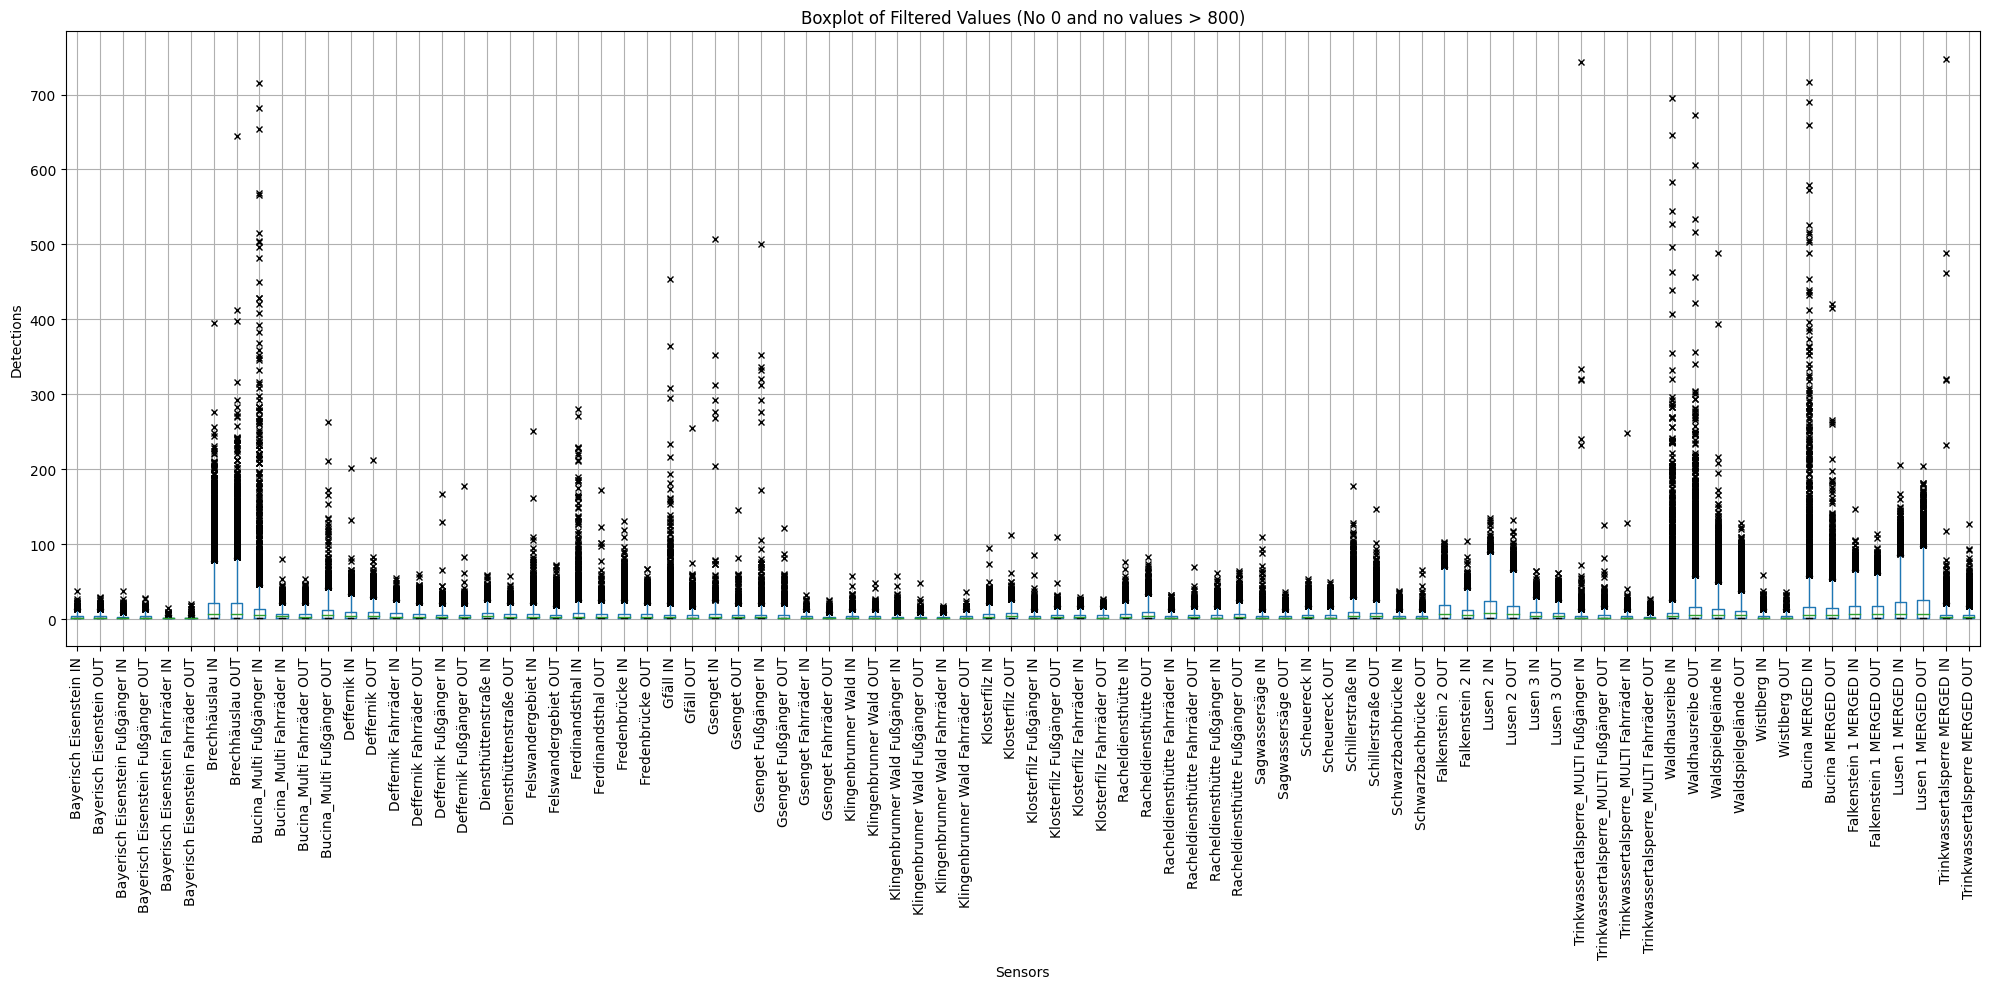

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is already defined earlier in your code

# Replace zero values with NaN to better visualize boxplots
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=3,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values (No 0 and no values > 800)')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


# Create target variable for first iteration

- Create a column for the sum of IN and OUT, to have a general representation of traffic with no direction.
- Create another column sustracting from this the OUTS for the park entrances


### Traffic:
Sum of INS and OUTS

DROP NON MERGED COLUMNS

In [160]:
# discard cyclyst and pedestrians for first iteration
non_cyclist_pedestrian = [col for col in df.columns 
                    if "Fahrräder" not in col 
                    and "Fußgänger" not in col]


In [161]:
df_merged = df[non_cyclist_pedestrian]

### Only keep rows from 2016 after a sensor was installed and create working sensors variable

In [162]:
df_merged = df_merged[df_merged.index >= "2016-05-10 03:00:00"]


Check rows where one sensor has IN values but NaN OUT values (or visceversa) and impute them with the value from same sensor column

In [163]:
map_sensors = {"Bayerisch Eisenstein": ['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT'],
            "Brechhäuslau": ['Brechhäuslau IN', 'Brechhäuslau OUT'],
            "Bučina": ['Bucina MERGED IN', 'Bucina MERGED OUT'],
            "Deffernik": ['Deffernik IN', 'Deffernik OUT'],
            "Diensthüttenstraße": ['Diensthüttenstraße IN', 'Diensthüttenstraße OUT'],
            "Felswandergebiet": ['Felswandergebiet IN', 'Felswandergebiet OUT'],
            "Ferdinandsthal": ['Ferdinandsthal IN', 'Ferdinandsthal OUT'],
            "Fredenbrücke": ['Fredenbrücke IN', 'Fredenbrücke OUT'],
            "Gfäll": ['Gfäll IN', 'Gfäll OUT'],
            "Gsenget": ['Gsenget IN', 'Gsenget OUT'],
            "Klingenbrunner Wald": ['Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT'],
            "Klosterfilz": ['Klosterfilz IN', 'Klosterfilz OUT'],
            "Racheldiensthütte": ['Racheldiensthütte IN', 'Racheldiensthütte OUT'],
            "Sagwassersäge": ['Sagwassersäge IN','Sagwassersäge OUT'],
            "Scheuereck": ['Scheuereck IN', 'Scheuereck OUT'],
            "Schillerstraße": ['Schillerstraße IN', 'Schillerstraße OUT'],
            "Schwarzbachbrücke": ['Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT'],
            "TFG Falkenstein 1": ['Falkenstein 1 MERGED IN', 'Falkenstein 1 MERGED OUT'],
            "TFG Falkenstein 2": ['Falkenstein 2 IN', 'Falkenstein 2 OUT'],
            "TFG Lusen 1": ['Lusen 1 MERGED IN', 'Lusen 1 MERGED OUT'],
            "TFG Lusen 2": ['Lusen 2 IN', 'Lusen 2 OUT'],
            "TFG Lusen 3": ['Lusen 3 IN', 'Lusen 3 OUT'],
            "Trinkwassertalsperre": ['Trinkwassertalsperre MERGED IN', 'Trinkwassertalsperre MERGED OUT'],
            "Waldhausreibe": ['Waldhausreibe IN', 'Waldhausreibe OUT'],
            "Waldspielgelände": ['Waldspielgelände IN', 'Waldspielgelände OUT'],
            "Wistlberg": ['Wistlberg IN', 'Wistlberg OUT']
        }


def impute_missing_values(df, sensor_columns):
    for sensor, (col1, col2) in sensor_columns.items():
        # Identify rows where one column is null and the other is not
        condition = df[[col1, col2]].isnull().any(axis=1) & df[[col1, col2]].notnull().any(axis=1)
        
        # Iterate through each row that matches the condition
        for index in df[condition].index:
            if pd.isna(df.loc[index, col1]) and pd.notna(df.loc[index, col2]):
                # Impute missing value in col1 with the value from col2
                df.loc[index, col1] = df.loc[index, col2]
            elif pd.isna(df.loc[index, col2]) and pd.notna(df.loc[index, col1]):
                # Impute missing value in col2 with the value from col1
                df.loc[index, col2] = df.loc[index, col1]
    
    return df

# Apply the imputation
df_merged = impute_missing_values(df_merged, map_sensors)

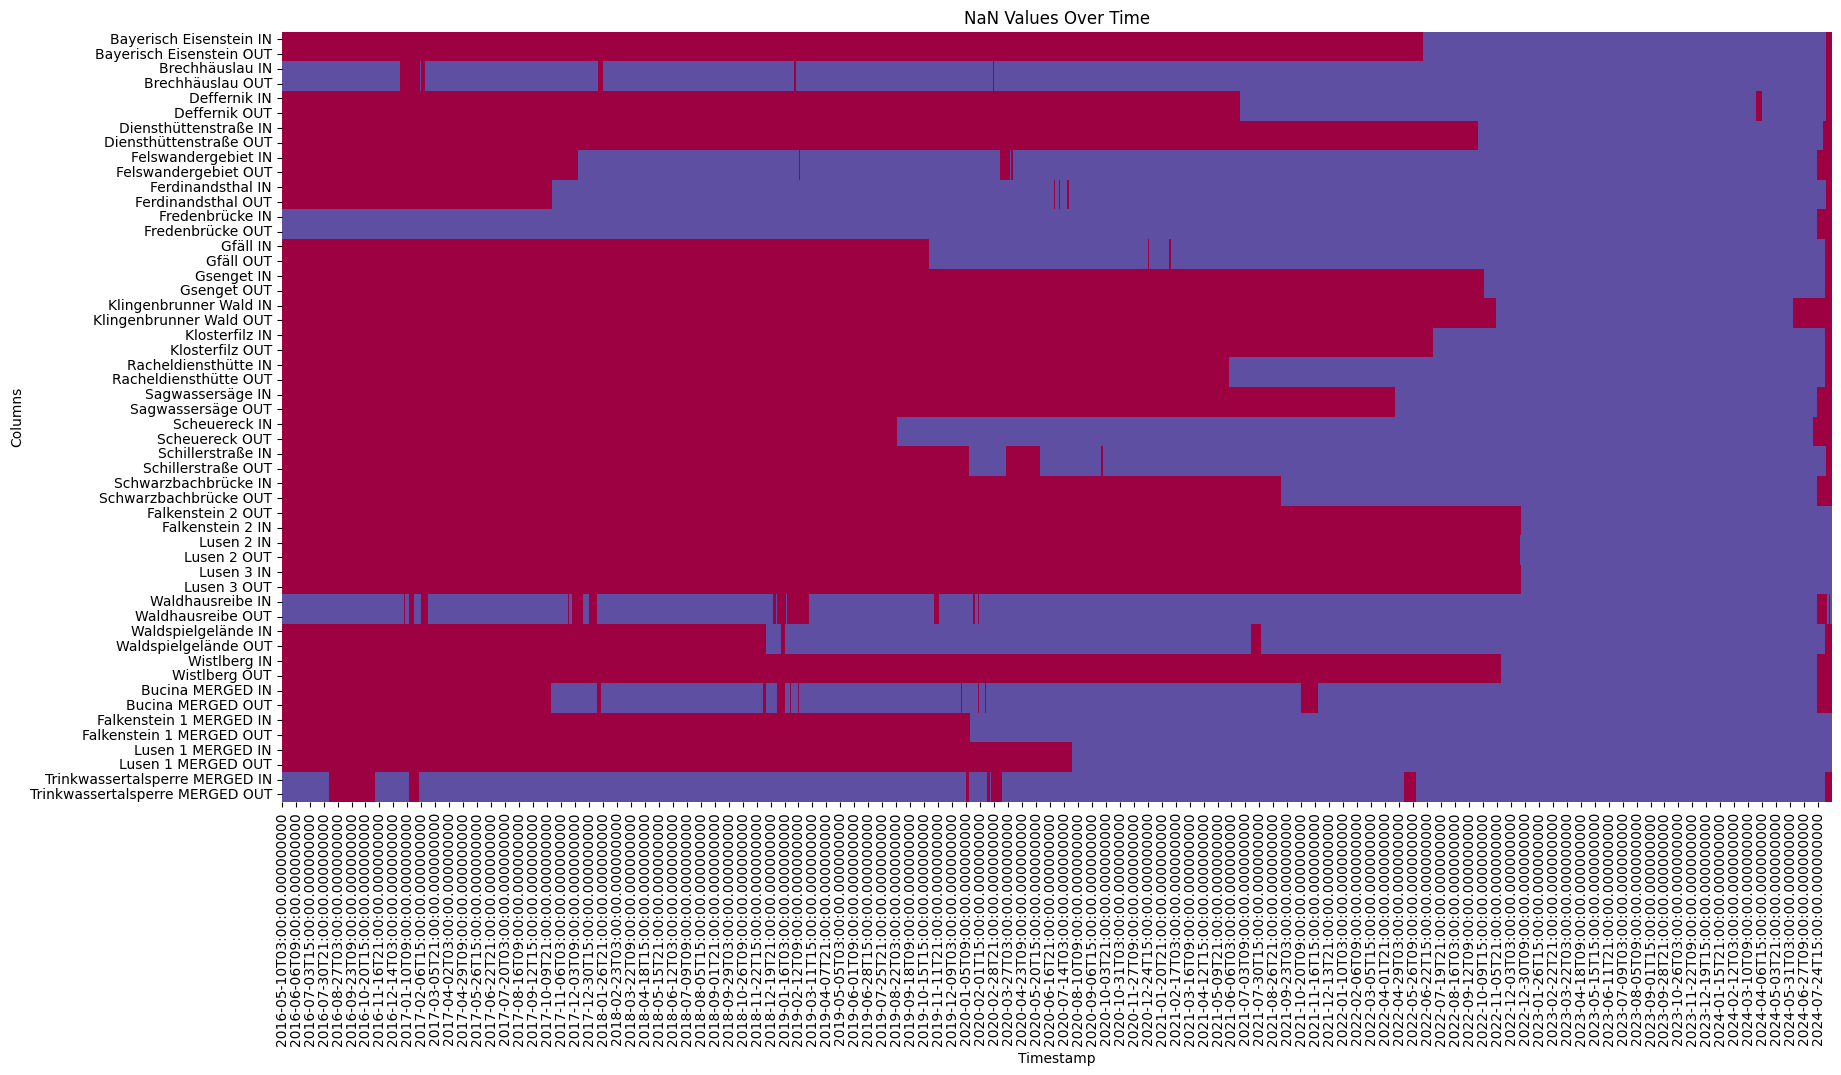

In [164]:
import seaborn as sns
# Create a DataFrame indicating NaN values (True if NaN, False otherwise)
nan_df = df_merged.isna()

# Set up the plot
plt.figure(figsize=(20, 10))

# Plot the heatmap
sns.heatmap(nan_df.T, cmap='Spectral_r', cbar=False)

# Set axis labels
plt.xlabel('Timestamp')
plt.ylabel('Columns')
plt.title('NaN Values Over Time')

# Show the plot
plt.show()

## Create dummy columns with active state for each sensor

In [165]:
def add_sensor_activity_columns(df, map_sensors):
    """
    Adds boolean columns to the DataFrame indicating activity for each sensor.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing sensor data.
    map_sensors (dict): A dictionary mapping sensor names to their corresponding columns.
    
    Returns:
    pd.DataFrame: The DataFrame with added '_active' columns for each sensor.
    """
    # Iterate over each key in the dictionary and create the new columns
    for sensor, columns in map_sensors.items():
        # Check if any of the specified columns have non-null values
        df[f"{sensor}_active"] = df[columns].notnull().any(axis=1).astype(int)
    
    return df

df_merged = add_sensor_activity_columns(df_merged, map_sensors)

In [166]:
df_merged['working_sensors'] = (df_merged[[col for col in df_merged.columns if "IN" in col or "OUT" in col]].notnull().sum(axis=1))

SUM OF INS AND OUTS / TRAFFIC

In [167]:

def calculate_traffic_metrics_abs(df):

    # Calculate total traffic
    df["traffic_abs"] = df.filter(regex='IN|OUT').sum(axis=1)

    # Calculate sum of 'IN' columns
    df["sum_IN_abs"] = df.filter(like='IN').sum(axis=1)

    # Calculate sum of 'OUT' columns
    df["sum_OUT_abs"] = df.filter(like='OUT').sum(axis=1)

    # Calculate difference between 'IN' and 'OUT' sums
    df['diff_abs'] = df['sum_IN_abs'] - df['sum_OUT_abs']

    # Calculate cumulative occupancy
    df['occupancy_abs'] = df['diff_abs'].cumsum().fillna(0)

    return df

df_merged =calculate_traffic_metrics_abs(df_merged)

# normalizing

1) step normalization for every segment of working sensors.
2) for every single value segment normalization was done with overall min() and max()

In [168]:
from sklearn.preprocessing import MinMaxScaler


def normalize_traffic_metrics(df):
    # Step 1: Identify the change points
    change_points = df['working_sensors'].ne(df['working_sensors'].shift()).cumsum()

    # Define dictionary mapping original column names to normalized column names
    metrics_dict = {
        'traffic_abs': 'traffic_norm',
        'sum_IN_abs': 'sum_IN_norm',
        'sum_OUT_abs': 'sum_OUT_norm',
        'diff_abs': 'diff_norm',
        'occupancy_abs': 'occupancy_norm'
    }

    # Dictionary to store min and max values for each metric
    min_max_dict = {key: {'min': None, 'max': None} for key in metrics_dict.keys()}

    # Compute overall min and max values across all segments
    for key in metrics_dict.keys():
        all_values = df[key].values
        min_max_dict[key]['min'] = np.min(all_values)
        min_max_dict[key]['max'] = np.max(all_values)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 100))

    # Normalize segments
    for segment in change_points.unique():
        segment_df = df[change_points == segment]

        for key in metrics_dict.keys():
            # Get min and max for the current metric
            min_value = min_max_dict[key]['min']
            max_value = min_max_dict[key]['max']
            
            # If the segment contains more than one value, scale normally
            if len(segment_df) > 1:
                values = segment_df[[key]].values
                scaled_values = scaler.fit_transform(values)
                df.loc[segment_df.index, metrics_dict[key]] = scaled_values.flatten()
            else:
                # For single-value segments, use overall min and max
                single_value = segment_df[key].values[0]
                normalized_value = (single_value - min_value) / (max_value - min_value) * 100
                df.loc[segment_df.index, metrics_dict[key]] = normalized_value

    return df

# Display the normalized DataFrame
normalized_df_merged = normalize_traffic_metrics(df_merged)

In [169]:
normalized_df_merged[[col for col in normalized_df_merged.columns if "_norm" in col or "_abs" in col]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72573 entries, 2016-05-10 03:00:00 to 2024-08-19 23:00:00
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_abs     72573 non-null  float64
 1   sum_IN_abs      72573 non-null  float64
 2   sum_OUT_abs     72573 non-null  float64
 3   diff_abs        72573 non-null  float64
 4   occupancy_abs   72573 non-null  float64
 5   traffic_norm    72573 non-null  float64
 6   sum_IN_norm     72573 non-null  float64
 7   sum_OUT_norm    72573 non-null  float64
 8   diff_norm       72573 non-null  float64
 9   occupancy_norm  72573 non-null  float64
dtypes: float64(10)
memory usage: 8.1 MB


In [170]:
normalized_df_merged[[col for col in normalized_df_merged.columns if "_norm" in col or "_abs" in col]].describe()

traffic_abs    sum_IN_abs   sum_OUT_abs      diff_abs  occupancy_abs  \
count  72573.000000  72573.000000  72573.000000  72573.000000   72573.000000   
mean      78.790418     39.269356     39.521062     -0.251705  -34696.531589   
std      161.779559     81.648107     83.687194     34.165682   15553.857212   
min        0.000000      0.000000      0.000000   -511.000000  -69599.000000   
25%        0.000000      0.000000      0.000000     -3.000000  -42828.000000   
50%       10.000000      4.000000      5.000000      0.000000  -33116.000000   
75%       76.000000     37.000000     36.000000      3.000000  -25701.000000   
max     2243.000000   1031.000000   1212.000000    685.000000     560.000000   

       traffic_norm   sum_IN_norm  sum_OUT_norm     diff_norm  occupancy_norm  
count  72573.000000  72573.000000  72573.000000  72573.000000    72573.000000  
mean       9.269105      9.112484      8.339802     47.504094       50.481666  
std       17.213093     16.894553     16.334915     15.033306       30.653164  
min        0.000000      0.000000      0.000000      0.000000        0.000000  
25%        0.000000      0.000000      0.000000     39.700375       24.140256  
50%        1.406470      1.246106      1.082251     44.943820       51.785714  
75%       10.139860     10.281280      8.527132     55.987055       78.522490  
max      100.000000    100.000000    100.000000    100.000000      100.000000

## Save locally and write to AWS

In [171]:
normalized_df_merged.to_csv(r"C:\Users\patricio\Documents\bf-dssgx\outputs\normalized_merged_data_historic_sensors_2016_2024.csv")

In [172]:
def write_csv_file_to_aws_s3(df: pd.DataFrame, path: str, **kwargs) -> pd.DataFrame:
    """Writes an individual CSV file to AWS S3.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the to_csv function.
    """

    wr.s3.to_csv(df, path=path, **kwargs)
    return

write_csv_file_to_aws_s3(
    df=normalized_df_merged,
    path=f"s3://{bucket}/{preprocessed_data_folder}/normalized_visitor_sensor_data_2016_2024.csv",
)

# Further exploration

In [47]:
import plotly.express as px
fig = px.line(df_merged, x=df_merged.index, y='traffic_abs', markers=True, title='Traffic Absolute',
              labels={'traffic_abs': 'Traffic Absolute', 'date': 'Date'})
fig.show()

In [48]:
fig = px.line(df_merged, x=df_merged.index, y='occupancy_abs', markers=True, title='Ocuppancy Absolute',
              labels={'occupancy_abs': 'Ocuppancy Absolute', 'date': 'Date'})
fig.show()

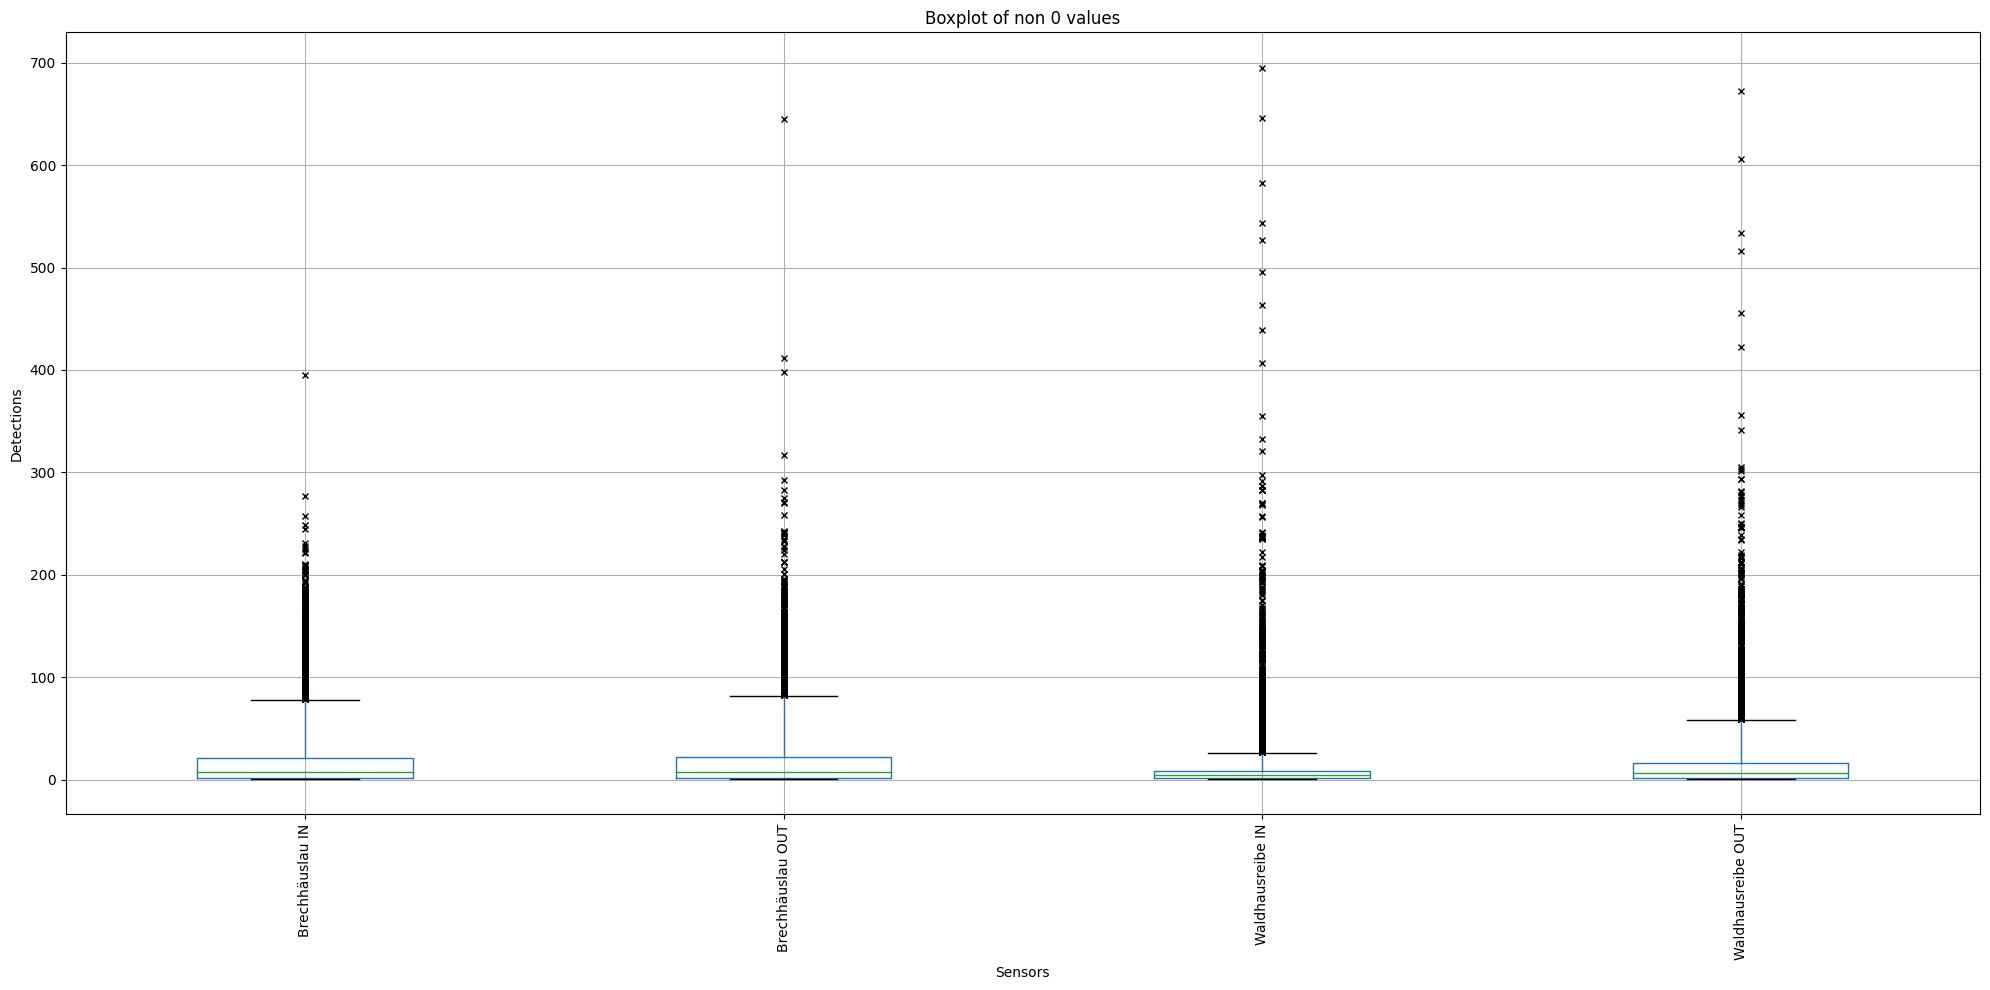

In [49]:
# Replace zero values with NaN to better visualize boxplots
df_filtered = df[['Brechhäuslau IN', 'Brechhäuslau OUT', 'Waldhausreibe IN',	'Waldhausreibe OUT']].replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=3,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of non 0 values')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")

In [50]:
# Create a DataFrame for 'IN' sensors
in_sums = df_merged[traffic_columns].filter(like='IN').sum().reset_index()
in_sums.columns = ['Sensor', 'Total_Count']
in_sums['Sensor'] = in_sums['Sensor'].str.replace(' IN', '')
in_sums['Direction'] = 'IN'

# Create a DataFrame for 'OUT' sensors
out_sums = df_merged[traffic_columns].filter(like='OUT').sum().reset_index()
out_sums.columns = ['Sensor', 'Total_Count']
out_sums['Sensor'] = out_sums['Sensor'].str.replace(' OUT', '')
out_sums['Direction'] = 'OUT'

# Combine the 'IN' and 'OUT' DataFrames
result_df = pd.concat([in_sums, out_sums])

# Reset the index to have a clean DataFrame
result_df.set_index(['Sensor', 'Direction'], inplace=True)



NameError: name 'traffic_columns' is not defined

In [ ]:
result_df.groupby("Direction").sum()

Total_Count
Direction             
IN           2849460.0
OUT          2868249.0

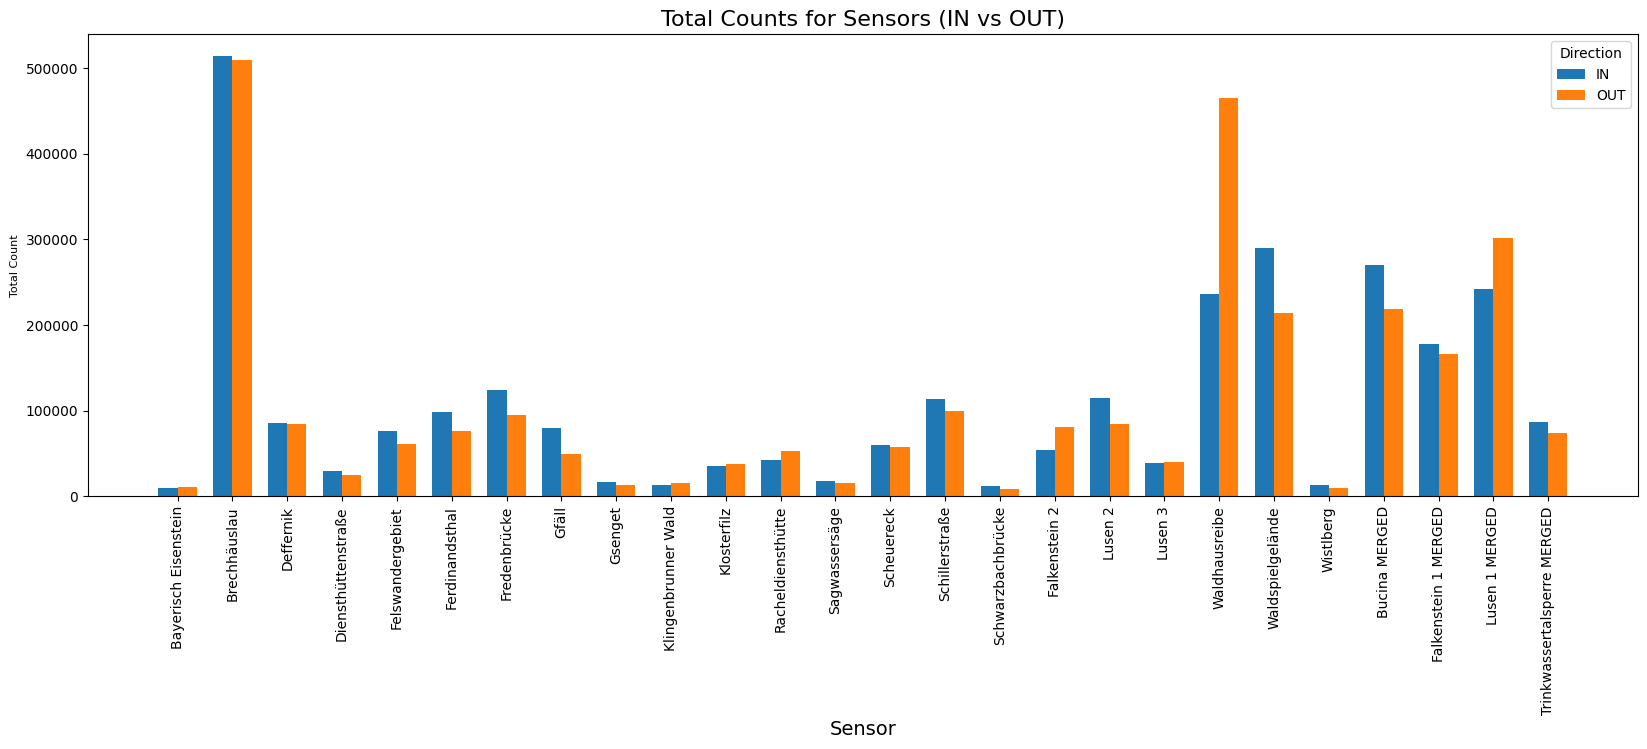

In [ ]:
# Reset the index to get 'Sensor' and 'Direction' as columns for easier plotting
df_plot = result_df.reset_index()

# Get unique sensor names and directions
sensors = df_plot['Sensor'].unique()
directions = df_plot['Direction'].unique()

# Set up the positions and width for the bars
x = np.arange(len(sensors))
width = 0.35  # Width of the bars

# Split the data for IN and OUT
in_counts = df_plot[df_plot['Direction'] == 'IN']['Total_Count']
out_counts = df_plot[df_plot['Direction'] == 'OUT']['Total_Count']

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(x - width/2, in_counts, width, label='IN')
plt.bar(x + width/2, out_counts, width, label='OUT')

# Adding titles and labels
plt.title('Total Counts for Sensors (IN vs OUT)', fontsize=16)
plt.xlabel('Sensor', fontsize=14)
plt.ylabel('Total Count', fontsize=8)
plt.xticks(x, sensors, rotation=90, fontsize=10)  # Set x-ticks with sensor names and rotate for better readability
plt.legend(title='Direction')

# Show plot
#plt.tight_layout()
plt.show()

COUNT OF SENSORS AT NIGHT

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (28,) and arg 1 with shape (27,).

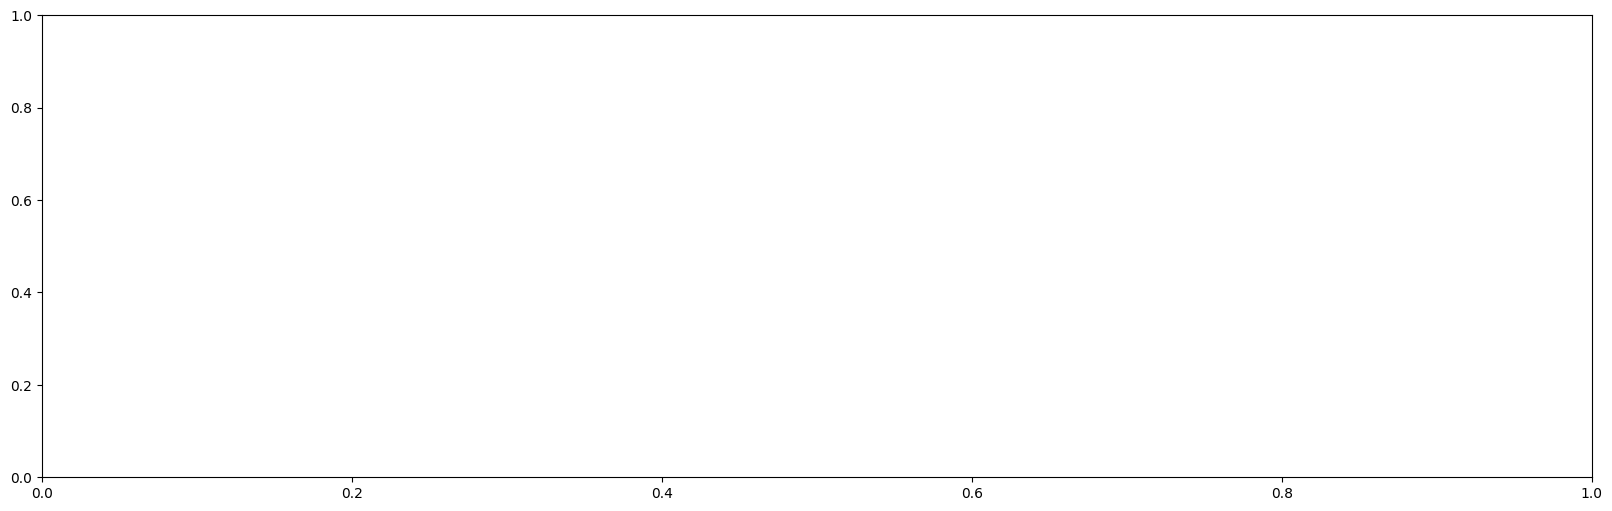

In [ ]:
times = df_merged.index.time
# Define time ranges
start_time = pd.to_datetime('23:00:00').time()
end_time = pd.to_datetime('05:00:00').time()

# Filter rows where time is between 23:00:00 and 05:00:00
mask = (times >= start_time) | (times <= end_time)
df_filtered = df_merged[mask]

# Create a DataFrame for 'IN' sensors
in_sums = df_filtered.filter(like='IN').sum().reset_index()
in_sums.columns = ['Sensor', 'Total_Count']
in_sums['Sensor'] = in_sums['Sensor'].str.replace(' IN', '')
in_sums['Direction'] = 'IN'

# Create a DataFrame for 'OUT' sensors
out_sums = df_filtered.filter(like='OUT').sum().reset_index()
out_sums.columns = ['Sensor', 'Total_Count']
out_sums['Sensor'] = out_sums['Sensor'].str.replace(' OUT', '')
out_sums['Direction'] = 'OUT'

# Combine the 'IN' and 'OUT' DataFrames
result_df = pd.concat([in_sums, out_sums])

# Reset the index to have a clean DataFrame
result_df.set_index(['Sensor', 'Direction'], inplace=True)

# Reset the index to get 'Sensor' and 'Direction' as columns for easier plotting
df_plot = result_df.reset_index()

# Get unique sensor names and directions
sensors = df_plot['Sensor'].unique()
directions = df_plot['Direction'].unique()

# Set up the positions and width for the bars
x = np.arange(len(sensors))
width = 0.35  # Width of the bars

# Split the data for IN and OUT
in_counts = df_plot[df_plot['Direction'] == 'IN']['Total_Count']
out_counts = df_plot[df_plot['Direction'] == 'OUT']['Total_Count']

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(x - width/2, in_counts, width, label='IN')
plt.bar(x + width/2, out_counts, width, label='OUT')

# Adding titles and labels
plt.title('Total Counts for Sensors between 23:00 and 05:00', fontsize=16)
plt.xlabel('Sensor', fontsize=14)
plt.ylabel('Total Count', fontsize=8)
plt.xticks(x, sensors, rotation=90, fontsize=10)  # Set x-ticks with sensor names and rotate for better readability
plt.legend(title='Direction')

# Show plot
#plt.tight_layout()
plt.show()